## Setup

In [1]:
!./venv/bin/pip install kaggle scikit-learn numpy matplotlib seaborn reparo

  Using cached kaggle-1.8.3-py3-none-any.whl.metadata (16 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached reparo-0.0.6-py3-none-any.whl.metadata (3.5 kB)
  Using cached black-26.1.0-cp313-cp313-macosx_11_0_arm64.whl.metadata (88 kB)
  Using cached bleach-6.3.0-py3-none-any.whl.metadata (31 kB)
  Using cached kagglesdk-0.1.15-py3-none-any.whl.metadata (13 kB)
  Using cached mypy-1.19.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.2 kB)
  Using cached protobuf-6.33.5-cp39-abi3-macosx_10_9_universal2.whl.metadata (593 bytes)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached tqdm-4.67.2-py3-none-any.whl.metadata (57 kB)
  Using cached types_requests-2.32.4.20260107-py3-none-any.whl.m

In [2]:
!kaggle datasets download kukuroo3/body-performance-data

Dataset URL: https://www.kaggle.com/datasets/kukuroo3/body-performance-data
License(s): CC0-1.0
100%|█████████████████████████████████████████| 249k/249k [00:00<00:00, 441kB/s]
100%|█████████████████████████████████████████| 249k/249k [00:00<00:00, 441kB/s]


In [3]:
!unzip body-performance-data.zip

Archive:  body-performance-data.zip
  inflating: bodyPerformance.csv     


In [4]:
!kaggle datasets download sanjeetsinghnaik/used-car-information

Dataset URL: https://www.kaggle.com/datasets/sanjeetsinghnaik/used-car-information
License(s): CC0-1.0
100%|█████████████████████████████████████████| 176k/176k [00:00<00:00, 344kB/s]
100%|█████████████████████████████████████████| 176k/176k [00:00<00:00, 343kB/s]


In [6]:
!unzip used-car-information.zip

Archive:  used-car-information.zip
  inflating: Dataset.csv             
  inflating: UsedCars_Banglore.csv   
  inflating: UsedCars_Chennai.csv    
  inflating: UsedCars_Combined.csv   
  inflating: UsedCars_Delhi.csv      
  inflating: UsedCars_Hyderabad.csv  
  inflating: UsedCars_Kolkata.csv    
  inflating: UsedCars_Mumbai.csv     
  inflating: UsedCars_Pune.csv       


## Imports

In [103]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC, SVR
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split

## Classification 

Body Performance dataset (based on homework 9)

### Load Dataset

In [106]:
body_df = pd.read_csv("./bodyPerformance.csv")

### Encode Categorical

In [107]:

cat_cols = ["gender"]

body_df = pd.get_dummies(body_df, columns=cat_cols, drop_first=True, dtype=int)

### Encode Class

In [108]:
class_mapping = {'A': 3, 'B': 2, 'C': 1, 'D': 0}
body_df['class'] = body_df['class'].map(class_mapping)

### Correlation

age                       -0.065612
height_cm                 -0.037753
weight_kg                 -0.214129
body fat_%                -0.341956
diastolic                 -0.066761
systolic                  -0.035484
gripForce                  0.136088
sit and bend forward_cm    0.588123
sit-ups counts             0.452832
broad jump_cm              0.262154
class                      1.000000
gender_M                  -0.075605
Name: class, dtype: float64


<Axes: >

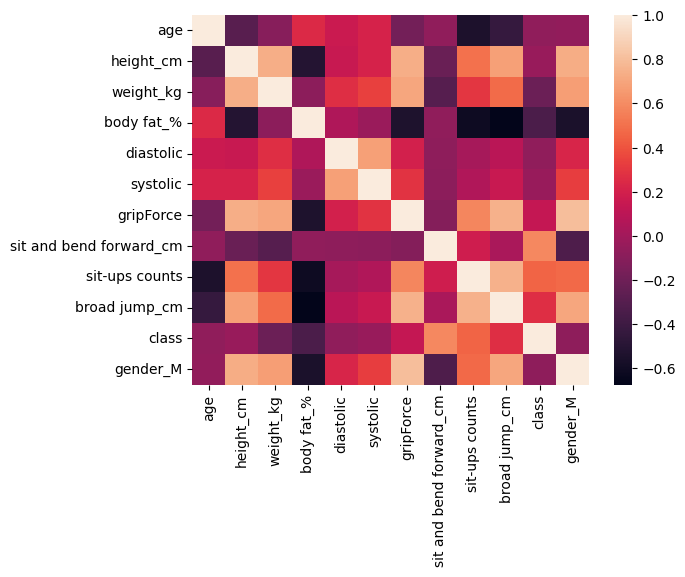

In [109]:
corr = body_df.corr()
print(corr["class"])
sns.heatmap(corr)

### Choose Important Features

In [110]:
THRESHOLD = 0.1
class_correlations = corr["class"].drop("class")
body_features = class_correlations.loc[lambda x: abs(x) > THRESHOLD]
body_features.keys()

Index(['weight_kg', 'body fat_%', 'gripForce', 'sit and bend forward_cm',
       'sit-ups counts', 'broad jump_cm'],
      dtype='str')

### Splitting the Dataset

In [111]:
X = body_df[body_features.keys()]
y = body_df['class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### TreeDecisionClassifier

The heatmaps below represent a function of two variables, where input variables are max_features and max_depth and output variable is the accuracy of the decision tree classifier. Input variables form a 2D surface, and the third dimension is the resulting accuracy. We can clearly see how for each heatmap there is a local maximum, from where the accuracy starts to gradually decrease.

The optimal hyperparameters are max_features taking values of 5 / 6 with max_depth of 8 / 9.

Since we only have a total of 6 features, increasing the number of max_features will not result in the same performance as for max_features=6

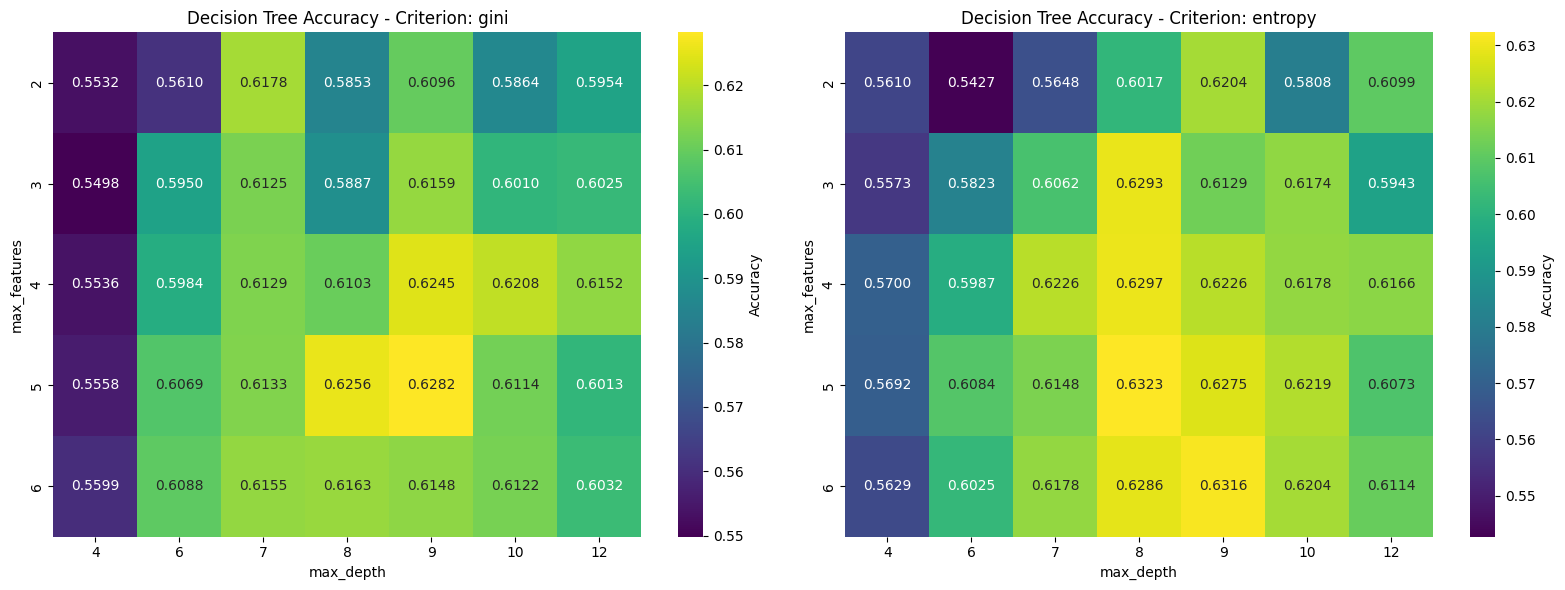

In [112]:
max_depth = [4, 6, 7, 8, 9, 10, 12]
max_features = [2, 3, 4, 5, 6]
criterion = ["gini", "entropy"]

results = {crit: np.zeros((len(max_features), len(max_depth))) for crit in criterion}

for crit_idx, crit in enumerate(criterion):
    for depth_idx, depth in enumerate(max_depth):
        for feat_idx, feat in enumerate(max_features):
            model = DecisionTreeClassifier(max_depth=depth, max_features=feat, criterion=crit, random_state=42)
            scaler = StandardScaler()
            
            clf = make_pipeline(scaler, model)
            clf.fit(X_train, y_train)
            
            y_pred = clf.predict(X_test)
            
            accuracy = accuracy_score(y_test, y_pred)
            results[crit][feat_idx, depth_idx] = accuracy

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, crit in enumerate(criterion):
    sns.heatmap(results[crit], 
                annot=True, 
                fmt='.4f',
                xticklabels=max_depth,
                yticklabels=max_features,
                cmap='viridis',
                ax=axes[idx],
                cbar_kws={'label': 'Accuracy'})
    axes[idx].set_xlabel('max_depth')
    axes[idx].set_ylabel('max_features')
    axes[idx].set_title(f'Decision Tree Accuracy - Criterion: {crit}')

plt.tight_layout()

### RandomForestClassifier

Entropy criterion also proves itself superior to gini, just as in previous plot, however after reaching the maximum accuracy they converge to equivalent performance. We can see that after ~24 estimators, the performance starts to degrade, as the model starts to overfit fo the given dataset. We can conclude that the optimal number of estimators is in the vicinity of 24 estimators.

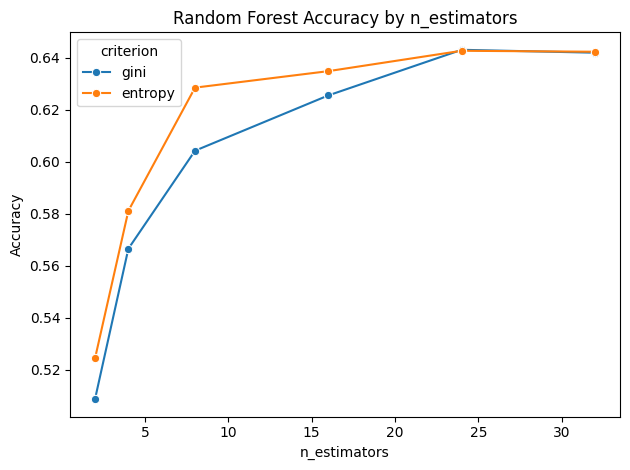

In [113]:
n_estimators = [2, 4, 8, 16, 24, 32]

results = {crit: [] for crit in criterion}

for crit_idx, crit in enumerate(criterion):
    for est_idx, n_est in enumerate(n_estimators):
        model = RandomForestClassifier(n_estimators=n_est, criterion=crit, random_state=42)
        scaler = StandardScaler()
        
        clf = make_pipeline(scaler, model)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        results[crit].append({'n_estimators': n_est, 'accuracy': accuracy})


results_df = pd.concat([
    pd.DataFrame(results[crit]).assign(criterion=crit) 
    for crit in criterion
], ignore_index=True)

sns.lineplot(data=results_df, x='n_estimators', y='accuracy', hue='criterion', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy by n_estimators')
plt.tight_layout()

In [114]:
results_df.T

,0,1,2,3,4,5,6,7,8,9,10,11
n_estimators,2,4,8,16,24,32,2,4,8,16,24,32
accuracy,0.508772,0.566629,0.60433,0.625607,0.64315,0.642031,0.524449,0.581187,0.628593,0.634938,0.642777,0.642404
criterion,gini,gini,gini,gini,gini,gini,entropy,entropy,entropy,entropy,entropy,entropy


### SVC

For the given dataset, RBF SVM has a better accuracy of around 0.63. Since the distribution of the columns resembles normal distribution (from previous homework), RBF kernel provides a better performance, since it also relies on the distribution center (aka mean) and the spread (aka stddev) of the data in higher dimensional space, forming n-dimensional spheres.

Polynomial SVM is only slightly inferior, since normal distribution can be approximated by polynomial functions on a given interval. Since the approximation is not as accurate, the accuracy is lower.

Sigmoid SVM shows the worst performance, since the data distribution does not resemble a sigmoid.

For all SVMs, the optimal hyperparameter value of C is between 0.2 and 0.5.

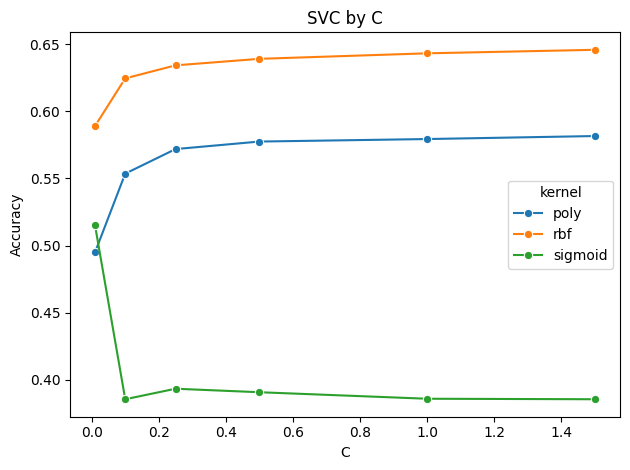

In [115]:
Cs = [0.01, 0.1, 0.25, 0.5, 1, 3/2]
kernels = ['poly', 'rbf', 'sigmoid']

results = {kernel: [] for kernel in kernels}

for kernel_idx, kernel in enumerate(kernels):
    for c_idx, C in enumerate(Cs):
        model = SVC(C=C, kernel=kernel, random_state=42)
        scaler = StandardScaler()
        
        clf = make_pipeline(scaler, model)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        results[kernel].append({'C': C, 'accuracy': accuracy})


results_df = pd.concat([
    pd.DataFrame(results[kernel]).assign(kernel=kernel) 
    for kernel in kernels
], ignore_index=True)

sns.lineplot(data=results_df, x='C', y='accuracy', hue='kernel', marker='o')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.title('SVC by C')
plt.tight_layout()

In [116]:
results_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
C,0.01,0.1,0.25,0.5,1.0,1.5,0.01,0.1,0.25,0.5,1.0,1.5,0.01,0.1,0.25,0.5,1.0,1.5
accuracy,0.494961,0.553565,0.571855,0.577454,0.579321,0.58156,0.589026,0.624487,0.634192,0.639044,0.64315,0.645763,0.515118,0.385592,0.39343,0.390817,0.385965,0.385592
kernel,poly,poly,poly,poly,poly,poly,rbf,rbf,rbf,rbf,rbf,rbf,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid,sigmoid


### KNN

KNN achieves the optimal performance when `n_neighbors = 11`, after which the accuracy of the model stabilizes itself at the same level. KNN is very fast and even for `n_neighbors = 3`, it achieves a decent accuracy of 0.58, considering that we have 4 classes.

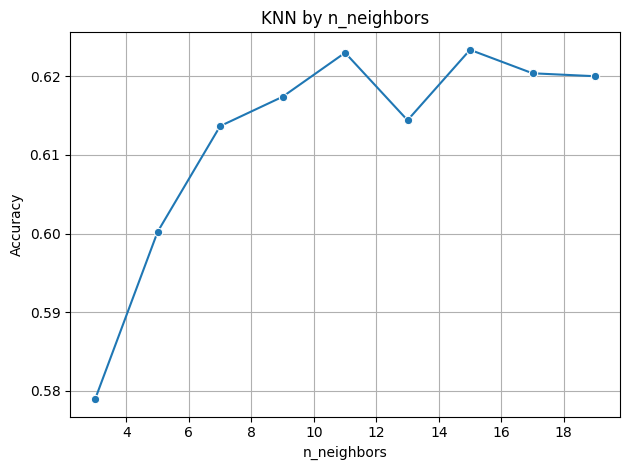

In [127]:
n_neighbors = [3, 5, 7, 9, 11, 13, 15, 17, 19]
results = []

for n_idx, n_n in enumerate(n_neighbors):
    model = KNeighborsClassifier(n_neighbors=n_n)
    scaler = StandardScaler()
    
    clf = make_pipeline(scaler, model)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results.append({'n_neighbors': n_n, 'accuracy': accuracy})


results_df = pd.DataFrame(results)

sns.lineplot(data=results_df, x='n_neighbors', y='accuracy', marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('Accuracy')
plt.title('KNN by n_neighbors')
plt.grid()
plt.tight_layout()

In [126]:
results_df.T

,0,1,2,3,4,5,6,7,8
n_neighbors,3.000000,5.000000,7.000000,9.000000,11.000000,13.000000,15.000000,17.000000,19.000000
accuracy,0.578947,0.600224,0.613662,0.617395,0.622994,0.614408,0.623367,0.620381,0.620007


## Regression

Used Car Price (based on homework 3)

### Load Dataset

In [128]:
cars_df = pd.read_csv("./Dataset.csv")

### Remove Unnecessary Columns

In [129]:
columns_to_remove = ["Id", "full_model_name", "model_name", "inv_car_price", "std_invprice"]

# There is an unnamed column so it should be removed by index
cars_df = cars_df.drop(cars_df.columns[0], axis=1).drop(columns=columns_to_remove)

### Add Brand Tier column

In [130]:
economy_brands = [
    "Maruti Suzuki",
    "Hyundai",
    "Tata",
    "Mahindra",
    "Renault",
    "Ford",
    "Datsun",
    "Fiat",
    "Isuzu"
]

standard_brands = [
    "Honda",
    "Toyota",
    "Volkswagen",
    "Skoda",
    "Nissan",
    "Kia",
    "MG",
    "Chevrolet",
    "Mitsubishi"
]

premium_brands = [
    "BMW",
    "Mercedes-Benz",
    "Audi",
    "Jaguar",
    "Land Rover",
    "Volvo",
    "MINI",
    "Jeep",
    "Porsche",
    "Lexus",
    "Bentley",
    "Lamborghini",
    "Mahindra-Renault"
]

cars_df["economy"] = cars_df["brand"].isin(economy_brands).astype(int)
cars_df["standard"] = cars_df["brand"].isin(standard_brands).astype(int)
cars_df["premium"] = cars_df["brand"].isin(premium_brands).astype(int)

brand_tier_map = {
    **{b: 1 for b in economy_brands},
    **{b: 2 for b in standard_brands},
    **{b: 3 for b in premium_brands},
}

cars_df["brand_tier"] = cars_df["brand"].map(brand_tier_map)

### Add City Tier column

In [131]:
large_cities = [
    "Delhi",
    "Mumbai",
    "Bangalore",
    "Chennai",
    "Hyderabad",
    "Pune"
]

medium_cities = [
    "Noida",
    "Ghaziabad",
    "Thane",
    "Navi Mumbai",
    "Dehradun"
]

small_cities = [
    "Lucknow",
    "Faridabad",
    "Agra",
    "Panchkula"
]

city_tier_map = {
    **{c: 3 for c in large_cities},
    **{c: 2 for c in medium_cities},
    **{c: 1 for c in small_cities},
}

cars_df["city_tier"] = cars_df["city"].map(city_tier_map)

### Encode Categorical

In [132]:
categorical_columns = ["fuel_type"]
def encode_categorical(df):
  # One-hot encode categorical columns
  df = pd.get_dummies(df, columns=categorical_columns, drop_first=False, dtype=int)
  return df

cars_df = encode_categorical(cars_df)

petrol_variants = [c for c in ("fuel_type_Petrol", "fuel_type_Petrol + 1") if c in cars_df.columns]
if petrol_variants:
    cars_df["fuel_type_Petrol"] = (cars_df[petrol_variants].sum(axis=1) > 0).astype(int)

cars_df = cars_df.drop(
    columns=["fuel_type_Petrol + 1", "fuel_type_Diesel", "fuel_type_Hybrid", "fuel_type_CNG + 1"],
    errors="ignore",
)

### Create Correlation List

In [133]:
precision = 4

def prec(n, p=precision):
  return f"{n:.{p}f}"

corr_methods = ["pearson", "kendall", "spearman"]
ignore_columns = []

corr_list = []

def describe_correlation(col: pd.Series):
  acc = 0
  temp_df = pd.DataFrame(col).drop(columns=ignore_columns).join(cars_df["price"])

  for corr_method in corr_methods:
    corr_matrix = temp_df.corr(method=corr_method)
    corr = corr_matrix.iloc[0, 1]
    acc += corr

  avg = acc / len(corr_methods)

  corr_list.append((col.name, avg))

ignore_cols = ["brand", "price", "petrol", "city"]

for column in cars_df.columns:
  if column in ignore_cols:
    # do nothing
    pass
  else:
    describe_correlation(cars_df[column])

sorted_corr = sorted(corr_list, key=lambda tup: abs(tup[1]), reverse=True)

### Define Training Columns

In [134]:
drop_cols = ["inv_car_age", "inv_brand", "inv_car_dist", "car_age",
             "distance below 30k km", "std_invdistance_travelled",
             "std_invrank", "best_buy1", "best_buy2"]
threshold = 0.1

training_cols = [col for col, num in sorted_corr if abs(num) > threshold and not col in drop_cols]

### Splitting the Dataset

In [135]:
X = cars_df[training_cols]
y = cars_df['price']

train_idx, test_idx = train_test_split(
    cars_df.index, test_size=0.2, random_state=42, shuffle=True
)

X_train = cars_df.loc[train_idx, training_cols].copy()
X_test  = cars_df.loc[test_idx, training_cols].copy()
y_train = cars_df.loc[train_idx, "price"]
y_test  = cars_df.loc[test_idx, "price"]

brand_mean_price = (
    cars_df.loc[train_idx]
    .groupby("brand")["price"]
    .mean()
)

X_train["brand_mean_price"] = cars_df.loc[train_idx, "brand"].map(brand_mean_price)
X_test["brand_mean_price"] = cars_df.loc[test_idx, "brand"].map(brand_mean_price)

# If a brand appears only in test, fall back to the overall train mean
fallback = float(y_train.mean())
X_train["brand_mean_price"] = X_train["brand_mean_price"].fillna(fallback)
X_test["brand_mean_price"] = X_test["brand_mean_price"].fillna(fallback)

### Creating the Pipeline

In [136]:
num_cols = ["price", "distance_travelled(kms)", "brand_rank", "car_age", "year",
  'new and less used', 'inv_car_dist', 'inv_car_age', 'inv_brand', 'brand_tier',
  "best_buy1", "best_buy2", "year", "brand_mean_price"]

num_cols_relevant = [
    col for col in num_cols
    if col not in drop_cols and col in X_train.columns
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols_relevant),
    ],
    remainder="passthrough",  # keep non-numeric columns as-is
)

def create_pipeline(base_model, scaler):
    return Pipeline([
        ("preprocess", preprocessor),
        ("model", TransformedTargetRegressor(
            regressor=base_model,
            transformer=scaler,
        )),
    ])

### SVR

Polynomial and RBF SVM achieved a similar performance, with a `r2` score of about 0.62 (taking r2 score for comparison instead of MSE since it is quite high, but equivalent to homework 3). Sigmoid SVM has a much more narrow interval of optimal C values, hovering around 0.01. Higher values of C punishes more for misclassified samples, and while for poly/rbf SVM it is fine and causes overfitting only for very large values (>100), sigmoid SVM seems much more sensitive to it. Below I did another graph to compare the performance of poly and rbf.

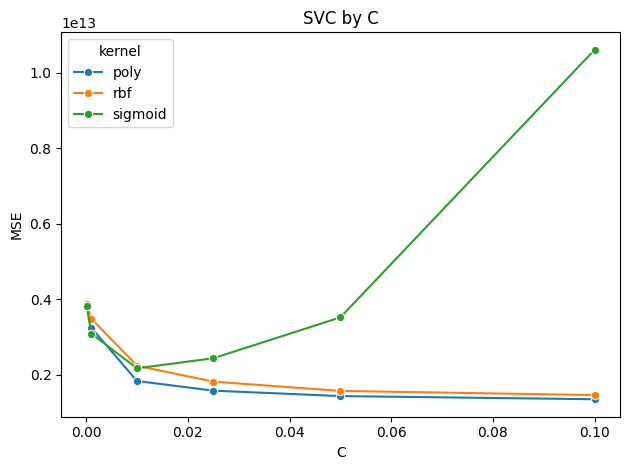

In [137]:
Cs = [0.0001, 0.001, 0.01, 0.025, 0.05, 0.1]
kernels = ['poly', 'rbf', 'sigmoid']

results = {kernel: [] for kernel in kernels}

for kernel_idx, kernel in enumerate(kernels):
    for c_idx, C in enumerate(Cs):
        model = SVR(C=C, kernel=kernel)
        
        clf = create_pipeline(model, StandardScaler())
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        accuracy = mean_squared_error(y_test, y_pred)
        results[kernel].append({'C': C, 'mse': accuracy})


results_df = pd.concat([
    pd.DataFrame(results[kernel]).assign(kernel=kernel) 
    for kernel in kernels
], ignore_index=True)

sns.lineplot(data=results_df, x='C', y='mse', hue='kernel', marker='o')
plt.xlabel('C')
plt.ylabel('MSE')
plt.title('SVC by C')
plt.tight_layout()

Poly and RBF SVM have a much better learning curve, starting to overfit for values of C>50. The optimal value of C seems to be around 10-20

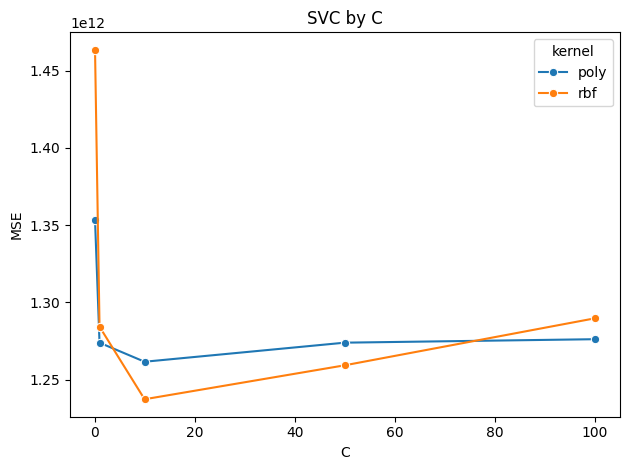

In [138]:
Cs = [0.1, 1, 10, 50, 100]
kernels = ['poly', 'rbf',]

results = {kernel: [] for kernel in kernels}

for kernel_idx, kernel in enumerate(kernels):
    for c_idx, C in enumerate(Cs):
        model = SVR(C=C, kernel=kernel)
        
        clf = create_pipeline(model, StandardScaler())
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        accuracy = mean_squared_error(y_test, y_pred)
        results[kernel].append({'C': C, 'mse': accuracy})


results_df = pd.concat([
    pd.DataFrame(results[kernel]).assign(kernel=kernel) 
    for kernel in kernels
], ignore_index=True)

sns.lineplot(data=results_df, x='C', y='mse', hue='kernel', marker='o')
plt.xlabel('C')
plt.ylabel('MSE')
plt.title('SVC by C')
plt.tight_layout()

### DecisionTreeRegressor

For the sake of comparison, I divided the MSEs by 1.3e+12. The criterion for the decision tree seems to have made small of a difference, with poission decision tree potentially having a slightly better average performance. However, Friedman MSE has the smaller MSE for `max_features = 5` and `max_depth = 6`. The optimal values are in the range of `max_features = [5, 7]` and `max_depth = [6, 8]`. With Friedman MSE, the decision tree achieved the best performance, even though the hyperparameter values were on the smaller side of optimal values, which is more optimal from computational perspective.

Note that for DecisionTreeRegressor MinMaxScaler was used instead of StandardScaler, since DecisionTreeRegressor with criterion=poisson cannot work with negative values.

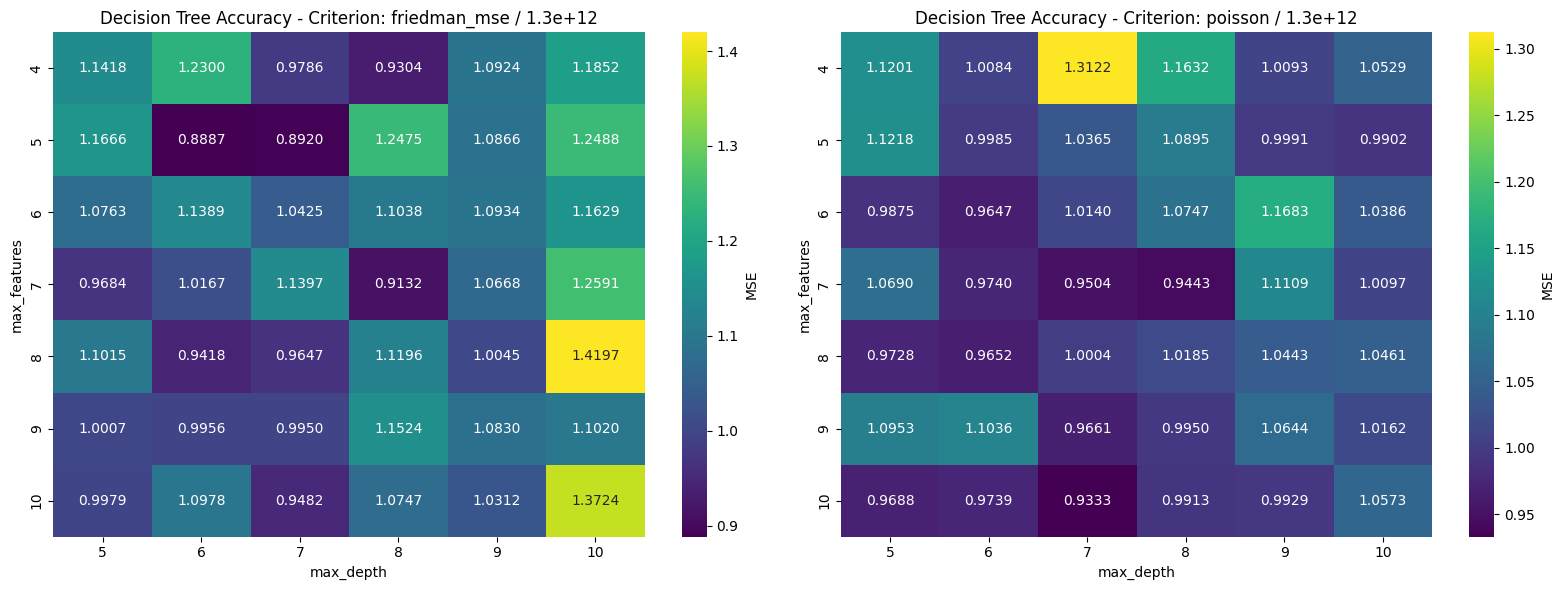

In [139]:
max_depth = [5, 6, 7, 8, 9, 10]
max_features = [4, 5, 6, 7, 8, 9, 10]
criterion = ["friedman_mse", "poisson"]

results = {crit: np.zeros((len(max_features), len(max_depth))) for crit in criterion}

for crit_idx, crit in enumerate(criterion):
    for depth_idx, depth in enumerate(max_depth):
        for feat_idx, feat in enumerate(max_features):
            model = DecisionTreeRegressor(max_depth=depth, max_features=feat, criterion=crit, random_state=42)
            
            clf = create_pipeline(model, MinMaxScaler())
            clf.fit(X_train, y_train)
            
            y_pred = clf.predict(X_test)
            
            mse = mean_squared_error(y_test, y_pred)
            results[crit][feat_idx, depth_idx] = mse / 1.3e+12

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, crit in enumerate(criterion):
    sns.heatmap(results[crit], 
                annot=True,
                fmt=".4f",
                xticklabels=max_depth,
                yticklabels=max_features,
                cmap='viridis',
                ax=axes[idx],
                cbar_kws={'label': 'MSE'})
    axes[idx].set_xlabel('max_depth')
    axes[idx].set_ylabel('max_features')
    axes[idx].set_title(f'Decision Tree Accuracy - Criterion: {crit} / 1.3e+12')

plt.tight_layout()

We can see by the cbar scale that the interval of errors has been shifted down, however the minimal MSE error has remained the same. The MSEs for other combinations of hyperparameters has decreased insignificantly. We can conclude that in this case, StandardScaler works a bit better.

Text(0.5, 1.0, 'Decision Tree Accuracy - Criterion: friedman_mse / 1.3e+12')

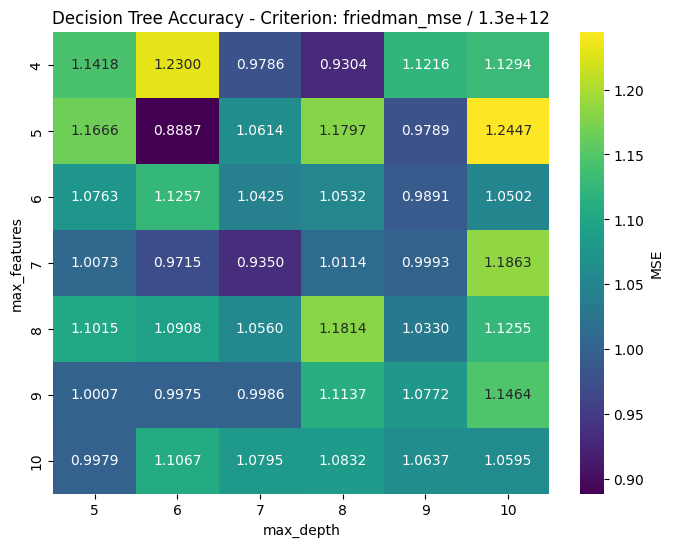

In [140]:
max_depth = [5, 6, 7, 8, 9, 10]
max_features = [4, 5, 6, 7, 8, 9, 10]

results = {crit: np.zeros((len(max_features), len(max_depth))) for crit in criterion}

for depth_idx, depth in enumerate(max_depth):
    for feat_idx, feat in enumerate(max_features):
        model = DecisionTreeRegressor(max_depth=depth, max_features=feat, criterion="friedman_mse", random_state=42)
        
        clf = create_pipeline(model, StandardScaler())
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        results[crit][feat_idx, depth_idx] = mse / 1.3e+12

_, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(results[crit], 
            annot=True,
            fmt=".4f",
            xticklabels=max_depth,
            yticklabels=max_features,
            cmap='viridis',
            ax=ax,
            cbar_kws={'label': 'MSE'})

ax.set_xlabel('max_depth')
ax.set_ylabel('max_features')
ax.set_title(f'Decision Tree Accuracy - Criterion: friedman_mse / 1.3e+12')

### RandomForestRegressor

For RandomForestRegressor, criterion is the function that measure the quality of a split. Absolute error has the worst performance, assuming because the predicted values are very high, so it cannot accurately measure how good the split it. Poisson is second best, while MSE criterion works the best, since it very effectively punishes large errors in deviance. As the number of estimators grows, MSE gets smaller for all criteria. After values of `n_estimators = 32`, the MSE starts to stagnate, indicating that it is close to being the optimal value to prevent overfitting.

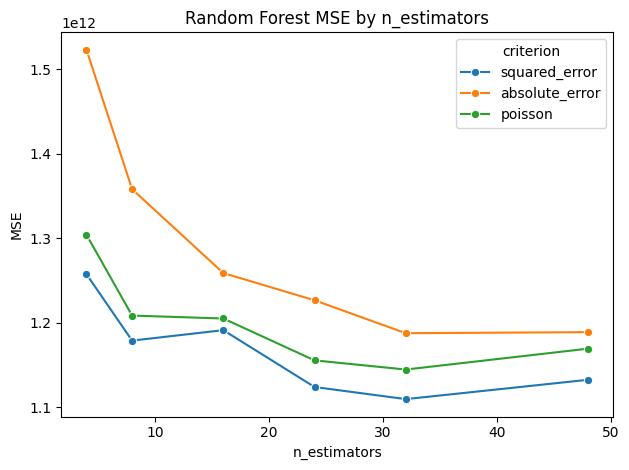

In [141]:
n_estimators = [4, 8, 16, 24, 32, 48]
criterion = ["squared_error", "absolute_error", "poisson"]

results = {crit: [] for crit in criterion}

for crit_idx, crit in enumerate(criterion):
    for est_idx, n_est in enumerate(n_estimators):
        model = RandomForestRegressor(n_estimators=n_est, criterion=crit, random_state=42)
        scaler = MinMaxScaler() if crit == "poisson" else StandardScaler()
        
        clf = create_pipeline(model, scaler)
        clf.fit(X_train, y_train)
        
        y_pred = clf.predict(X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        results[crit].append({'n_estimators': n_est, 'mse': mse})


results_df = pd.concat([
    pd.DataFrame(results[crit]).assign(criterion=crit) 
    for crit in criterion
], ignore_index=True)

sns.lineplot(data=results_df, x='n_estimators', y='mse', hue='criterion', marker='o')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('Random Forest MSE by n_estimators')
plt.tight_layout()

### KNN

The graph between n_neighbors and MSE looks shows us that there is a local minimum, for which MSE is the smallest. For `n_neighbors = 15` the KNN achieves the best performance, for values larger than that the model fails to capture local trends and provides a more inaccurate result.

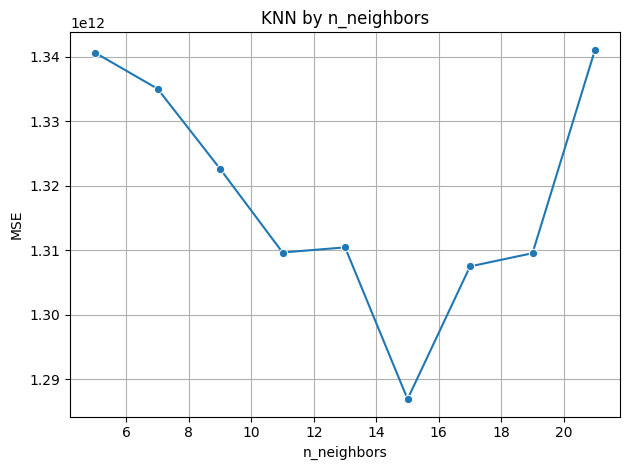

In [ ]:
n_neighbors = [5, 7, 9, 11, 13, 15, 17, 19, 21]
results = []

for n_idx, n_n in enumerate(n_neighbors):
    model = KNeighborsRegressor(n_neighbors=n_n)
    scaler = StandardScaler()
    
    clf = make_pipeline(scaler, model)
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    results.append({'n_neighbors': n_n, 'mse': mse})


results_df = pd.DataFrame(results)

sns.lineplot(data=results_df, x='n_neighbors', y='mse', marker='o')
plt.xlabel('n_neighbors')
plt.ylabel('MSE')
plt.title('KNN by n_neighbors')``
plt.grid()
plt.tight_layout()